# Volatility surface calibration
#### Roland Grinis, Dmitry Bazanov, Maksim Sosnin, Ivan Novikov

In [1]:
import numpy as np
import pandas as pd
import numba as nb
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
plt.style.use("dark_background")
pd.set_option('display.max_columns', 1000)
pd.set_option("display.precision", 2)
%matplotlib inline

## 1. Implied Volatility

#### 1.1 CDF Approximation
Zelen & Severo approximation for the standard normal CDF $\text{N}(x) = \frac{1}{\sqrt{2\pi}}\int^x_{-\infty} \text{d}z \exp(-z^2/2)$ is given by: 
$$
\text{N}(x) = 1 - \text{N}'(x) \sum_{i=1}^{5} b_i t^i + \epsilon (x)
$$
where $t = (1 + b_0 x)^{-1}$, the error is bounded by $|\epsilon (x)| < 7.5 \cdot 10^{-8}$ and the coefficients $b_i$ are fixed (see implementation).

$$
b_0 = 0.2316419 
$$
$$
b_1 = 0.319381530 
$$
$$
b_2 = -0.356563782 
$$
$$
b_3 = 1.781477937 
$$
$$
b_4 = -1.821255978 
$$
$$
b_5 = 1.330274429
$$

In [2]:
from pyquant.utils import normal_cdf_vec

x = np.linspace(-5, 5, 100)
np.max(np.abs(norm.cdf(x) - normal_cdf_vec(x)))

np.float64(7.214301397939771e-08)

#### 1.2 Black-Scholes-Merton formulae revisited

Present value:
$$
PV_{C,P} = \pm S_t \text{N}(\pm d_1) - \pm e^{-r(T-t)}K \text{N}(\pm d_2)
$$

where $d_1 = \frac{\log \frac{f_t}{K} + \frac{1}{2}\sigma^2(T-t) }{\sigma \sqrt{T-t}}$ and $d_2 = d_1 - \sigma \sqrt{T-t}$, and $f_t = S_t / e^{-r(T-t)}$


Delta risk:
$$
\Delta_{C,BSM} = \frac{\partial PV_C}{\partial S_t} = N(d_1), \quad \Delta_{P,BSM} = \frac{\partial PV_P}{\partial S_t} = \Delta_{C,BSM} - 1
$$

Gamma risk:
$$
\Gamma_{BSM} =  \frac{\partial \Delta_{BSM}}{\partial S_t} = \frac{\text{N}'(d_1)}{S_t\sigma \sqrt{T-t}}
$$

Vega risk:
$$
\mathcal{V}_{BSM}= \frac{\partial PV}{\partial \sigma} =\text{N}'(d_1) S_t \sqrt{T-t}
$$

Vanna risk:
$$
\text{Vanna}_{BSM} = \frac{\partial \mathcal{V}_{BSM}}{\partial S_t} = \mathcal{V}_{BSM} \cdot \frac{d_2}{\sigma S_t}
$$

Volga/Vomma risk:
$$
\text{Volga}_{BSM} =  \frac{\partial \mathcal{V}_{BSM}}{\partial \sigma} = \mathcal{V}_{BSM} \frac{d_1 d_2}{\sigma}
$$

#### 1.2 Newton-Raphson for Implied Volatility

Implied volatility is defined as the volatility level $\sigma$ one needs to plug into the Black-Scholes formula $\mathcal{BS}$ to obtain the market present value $PV^{m k t}$ of the option:

$$
g\left(\sigma_{\text {imp }}\right)=PV^{m k t}(K, T)-\mathcal{BS}\left(t_0=0, S_0 ; K, T, \sigma_{\text {imp }}, r\right)=0 
$$

Given an initial guess for the implied volatility, i.e. $\sigma_{\text {imp }}^{(0)}$, we can find the next approximations, $\sigma_{\text {imp }}^{(k)}, k=1,2, \ldots$, by means of the Newton-Raphson iterative algorithm, as follows

$$
\sigma_{\text {imp }}^{(k+1)}=\sigma_{\text {imp }}^{(k)}-\frac{g\left(\sigma_{\text {imp }}^{(k)}\right)}{g^{\prime}\left(\sigma_{\text {imp }}^{(k)}\right)}, \text { for } k \geq 0 .
$$
where actually the derivative is negative vega:
$$
g^{\prime}\left(\sigma_{\text {imp }}^{(k)} \right) = - \mathcal{V}_{BSM}(\sigma_{\text {imp}}^{(k)})
$$
This algorithm has second order convergence.

For deep OTM options vega is close to zero - this might lead to instabilities for the Newton-Raphson method. To deal with this, we augment the later with the bisection method.

In [3]:
from pyquant.black_scholes import *

In [4]:
bs_calc = BSCalc()

In [5]:
forward = Forward(Spot(100.), ForwardYield(0.01), TimeToMaturity(0.8))

In [6]:
PV_put = bs_calc.premium(
    forward, 
    Vanilla(
        OptionType(False),
        Strike(80.),
        Notional(1.),
        TimeToMaturity(0.8)
    ),
    ImpliedVol(.3)
)
PV_put.pv

2.5612819321972253

In [7]:
abs(bs_calc.implied_vol(
    forward, 
    Strike(80.), 
    PV_put).sigma - .3)

1.6887047316060944e-12

In [8]:
PV_call = bs_calc.premium(
    forward, 
    Vanilla(
        OptionType(True),
        Strike(120.),
        Notional(1.),
        TimeToMaturity(0.8)
    ),
    ImpliedVol(.3)
)
PV_call.pv

4.52881138621516

In [9]:
abs(bs_calc.implied_vol(
    forward, 
    Strike(120.), 
    PV_call).sigma - .3)

1.913857961000076e-12

#### 1.3 Delta-space quotes

In some markets, e.g. FX, quotes for the volatility smile are not presented as an options chain of strikes and implied vols. Rather, markets makers quote:
- the ATM straddle $\sigma_{ATM} = \sigma(K=f_t)$
- the risk-reversal $\sigma_{\delta RR} = \sigma(K_{\delta,c}) - \sigma(K_{\delta,p})$
- the butterfly $\sigma_{\delta BF} = \frac{1}{2}[\sigma(K_{\delta,c}) + \sigma(K_{\delta,p})] - \sigma_{ATM}$

where $K_{\delta,c}$ and $K_{\delta,p}$ are respectively call and put strikes for which the Black-Scholes delta is exatly $\Delta_{BSM} = \pm \delta$. Typically one takes $\delta=\frac{1}{4}$ and $\delta=\frac{1}{10}$ for 25RR, 25BF and 10RR, 10BF respectively. 

One can easily map delta-space quotes to strikes chain solving:
$$
g(K) = \Delta_{BSM} \pm \delta = 0
$$
which reduces to $\text{N}(d_{1}) = \delta$ for calls and $\text{N}(d_{1}) = 1 - \delta$ for puts. The easiest approach to find the root will be Newton-Raphson with:
$$
g'(K) = -\frac{1}{K \sigma \sqrt{T-t}}\text{N}'(d_{1}) 
$$

And the implied volatilities are simple to obtain:

$$
\sigma(K_{\delta,c}) = \frac{1}{2}\sigma_{\delta RR} + \sigma_{\delta BF} + \sigma_{ATM} 
$$

$$
\sigma(K_{\delta,p}) = - \frac{1}{2}\sigma_{\delta RR} + \sigma_{\delta BF} + \sigma_{ATM}
$$

Models are typically calibrated to chain space quotes. In general to obtain delta-space quotes from the chain space, one first needs to calibrate a model. 

In [10]:
K_put = bs_calc.strike_from_delta(forward, Delta(-0.25), ImpliedVol(0.3))
K_put.K

87.19837145162928

In [11]:
abs(bs_calc.delta(
    forward, 
    Vanilla(
        OptionType(is_call=False),
        K_put,
        Notional(1.),
        TimeToMaturity(0.8)
    ),
    ImpliedVol(0.3)).pv + 0.25)

0.0

In [12]:
K_put = bs_calc.strike_from_delta(forward, Delta(-0.1), ImpliedVol(0.3))
K_put.K

74.09097394683651

In [13]:
abs(bs_calc.delta(
    forward, 
    Vanilla(
        OptionType(is_call=False),
        K_put,
        Notional(1.),
        TimeToMaturity(0.8)
    ),
    ImpliedVol(0.3)).pv + 0.1)

2.7755575615628914e-17

In [14]:
K_call = bs_calc.strike_from_delta(forward, Delta(0.25), ImpliedVol(0.3))
K_call.K

125.23033444884504

In [15]:
abs(bs_calc.delta(
    forward, 
    Vanilla(
        OptionType(is_call=True),
        K_call,
        Notional(1.),
        TimeToMaturity(0.8)
    ),
    ImpliedVol(0.3)).pv - 0.25)

1.970645868709653e-14

In [16]:
K_call = bs_calc.strike_from_delta(forward, Delta(0.1), ImpliedVol(0.3))
K_call.K

147.3847708914916

In [17]:
abs(bs_calc.delta(
    forward, 
    Vanilla(
        OptionType(is_call=True),
        K_call,
        Notional(1.),
        TimeToMaturity(0.8)
    ),
    ImpliedVol(0.3)).pv - 0.1)

6.938893903907228e-17

#### 1.4 Computing the volatility smile

In [18]:
strikes = np.array([1300., 1400, 1500, 1600, 1700, 1800., 1900, 2000, 2100, 2200])
tau = 0.01
F = 1723.75
forward = Forward(Spot(F), ForwardYield(0.01), TimeToMaturity(tau))
pvs = np.array([ 1.72375, 1.72375, 3.4475, 6.895, 26.718125, 11.204375,
                4.309375, 1.72375, 0.861875, 0.861875])

In [19]:
implied_vols = bs_calc.implied_vols(
    forward, 
    Strikes(strikes),
    Premiums(pvs)
).data
implied_vols

array([1.40286434, 1.07977775, 0.88064766, 0.65471368, 0.54875586,
       0.53543347, 0.68346774, 0.79146338, 0.90117135, 1.07876289])

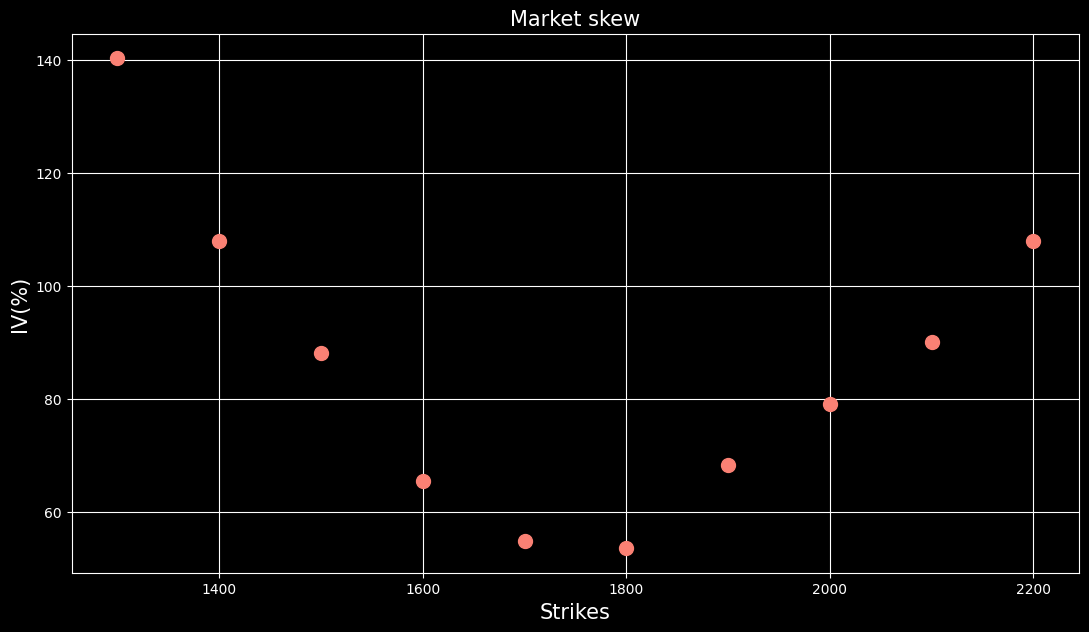

In [20]:
plt.figure(figsize=(13, 7))
plt.plot(strikes, 100*implied_vols, '.C3', markersize=20)
plt.title('Market skew', fontsize=15)
plt.xlabel('Strikes', color='white', fontsize=15)
plt.ylabel('IV(%)', color='white', fontsize=15)
plt.grid()
plt.show()

## 2. Levenberg-Marquardt algorithm

The Levenberg-Marquardt algorithm combines two numerical minimization algorithms: the gradient descent method and the
Gauss-Newton method. In the gradient descent method, the sum of the squared errors is reduced by updating the parameters in the steepest-descent direction. In the
Gauss-Newton method, the sum of the squared errors is reduced by assuming the least
squares function is locally quadratic in the parameters, and finding the minimum of
this quadratic. The Levenberg-Marquardt method acts more like a gradient-descent
method when the parameters are far from their optimal value, and acts more like the
Gauss-Newton method when the parameters are close to their optimal value.

["The Levenberg-Marquardt algorithm for
nonlinear least squares curve-fitting problems" Henri P. Gavin 2022](https://people.duke.edu/~hpgavin/ExperimentalSystems/lm.pdf)

##### Levenberg-Marquardt

$$
\chi^2(\boldsymbol{\theta}) =(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}(\boldsymbol{\theta}))^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}(\boldsymbol{\theta}));
$$

$$ W_{ii} = \frac{1}{w_i^2}, \quad \sigma = [\sigma_i], \quad \hat{\sigma} = [\hat{\sigma_i}] $$

##### Gradient descent

$$
\begin{aligned}
\frac{\partial}{\partial \boldsymbol{\theta}} \chi^2 & =-2(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})^{\top} \boldsymbol{W} \boldsymbol{J}; \quad \boldsymbol{J} = \left[\frac{\partial \hat{\boldsymbol{\sigma}}(\boldsymbol{p})}{\partial \boldsymbol{p}}\right]
\end{aligned}
$$

$$ \text{step: } h_g = \lambda \boldsymbol{J}^T \boldsymbol{W} (\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}); \quad \lambda > 0 \text{ - learning rate} $$

##### Gauss-Newton Method  $ \quad |h| << 1 $

$$\hat{\boldsymbol{\sigma}}(\boldsymbol{\theta}+\boldsymbol{h}) \approx \hat{\boldsymbol{\sigma}}(\boldsymbol{\theta})+\boldsymbol{J} \boldsymbol{h}$$

Note the approximations:
$$
\chi^2(\boldsymbol{\theta}+\boldsymbol{h}) \approx \boldsymbol{\sigma}^{\top} \boldsymbol{W} \boldsymbol{\sigma}+\hat{\boldsymbol{\sigma}}^{\top} \boldsymbol{W} \hat{\boldsymbol{\sigma}}-2 \boldsymbol{\sigma}^{\top} \boldsymbol{W} \hat{\boldsymbol{\sigma}}-2(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})^{\top} \boldsymbol{W} \boldsymbol{J} \boldsymbol{h}+\boldsymbol{h}^{\top} \boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J} \boldsymbol{h}
$$
so that
$$
\frac{\partial}{\partial \boldsymbol{h}} \chi^2(\boldsymbol{\theta}+\boldsymbol{h}) \approx-2(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})^{\top} \boldsymbol{W} \boldsymbol{J}+2 \boldsymbol{h}^{\top} \boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J}
$$

Hence the optimal step:
$$
\left[\boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J}\right] \boldsymbol{h}_{\mathrm{gn}}=\boldsymbol{J}^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})
$$

##### Levenberg Equation

$$
\left[\boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J}+\lambda \boldsymbol{I}\right] \boldsymbol{h}_{\mathrm{lm}}=\boldsymbol{J}^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})
$$

##### Levenberg-Marquardt equation

$$
\left[\boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J}+\lambda \operatorname{diag}\left(\boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J}\right)\right] \boldsymbol{h}_{\mathrm{Im}}=\boldsymbol{J}^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})
$$

##### Improvement metric

If using LM equation:
$$
\boldsymbol{\mu}(\boldsymbol{h}_{\mathrm{lm}}) = \frac{\chi^2(\boldsymbol{\theta})-\chi^2\left(\boldsymbol{\theta}+\boldsymbol{h}_{\mathrm{lm}}\right)}{\boldsymbol{h}_{\mathrm{lm}}^{\top}\left(\lambda \operatorname{diag}\left(\boldsymbol{J}^{\top} \boldsymbol{W} J\right) \boldsymbol{h}_{\mathrm{lm}}+\boldsymbol{J}^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}(\boldsymbol{\theta}))\right)}
$$


$$
\mu << 1 \quad \rightarrow \quad \text{Gradient descent mode} \quad (\boldsymbol{\lambda} \text{ - is increasing})
$$

$$
\mu >> 1 \quad \rightarrow \quad \text{Gauss-Newton mode } \quad (\boldsymbol{\lambda} \text{ - is decreasing})
$$

##### Step procedure

$$ \boldsymbol{\lambda} = 10^{-2}  \quad \quad L_{\downarrow} = 2 \quad \quad L_{\uparrow} = 2 \quad \quad \boldsymbol{\epsilon} = 10^{-1} $$

$$ \text{solve the L-M equation with} \boldsymbol{\lambda} \quad \rightarrow \quad \boldsymbol{h}_{\mathrm{lm}} $$

$$
\begin{aligned}
& \text{if } \quad \boldsymbol{\mu}(\boldsymbol{h}_{\mathrm{lm}}) > \boldsymbol{\epsilon}: \\
& \quad \quad \boldsymbol{\theta} = \boldsymbol{\theta} + \boldsymbol{h}_{\mathrm{lm}} \\
& \quad \quad \boldsymbol{\lambda} = \max (\frac{\lambda}{L_{\downarrow}}, 10^{-7}) \\
& \text{else: } \\
&  \quad \quad \boldsymbol{\lambda} = \min (\lambda L_{\uparrow} , 10^{7})
\end{aligned}
$$

##### Convergence Criteria

- Gradient convergence: $\left|\boldsymbol{J}^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})\right|< 10^{-3}$;
- Parameters convergence: $\max \left|h_i / \theta_i\right|<10^{-3} ;$ or
- Convergence in $\chi^2:$ uses the value of the reduced $\chi^2, \chi_\nu^2=\chi^2 /(m-n+1)$, where $n$ - sample size, $m$ - param. dimension.

##### Error analysis

$$ \chi_\nu^2 >> 1 \text{ - poor fit };  \quad \chi_\nu^2 \approx 1 \text{ - fit error of same order as measurement error }; \quad \chi_\nu^2 << 1 \text{ - overfit }; $$

$$ \text{parameters covariance: } (\boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J})^{-1} $$

## 3. SABR calibration

This is a stochastic volatility model that describes the dynamics of the forward directly in the risk neutral measure:

$$ df_t = \alpha_t f_t^{\beta} dW_t^1 $$ 

$$ d \alpha_t = v \alpha_t dW_t^2$$ 

$$E[dW_t^1, dW_t^2] = \rho dt$$

where $-1 < \rho < 1$ is the vol correlation, $0 \leq \beta \leq 1$ is the CIR exponent and the Wiener processes are independent.

Hagan derived an asymptotic formula for implied volatility as $T \rightarrow 0$:

$$
\sigma_B(x, T) =I_B^0(x) \left(1 + I_H^1(x)T\right) + \mathcal{O}(T^2), \quad x = \ln \frac{f}{K}
$$

Hagan's original formula has arbitrage for small strikes and large maturities, and is inconsistent as $\beta \rightarrow 1$ at order zero. 

For the corrected expression see the [symbolic calculations notebook](sym_gradient_sv.ipynb) or the [source code](pyquant/sabr.py).

For ATM we can approximate the formula as:
$$\sigma_{ATM} = \sigma_{B} (f, f) \approx  \frac{\alpha(1+[\frac{(1-\beta)^2}{24} \frac{\alpha^2}{(f)^{2-2\beta}} + \frac{\rho \beta v \alpha}{4(f)^{(1-\beta)}}+\frac{2-3\rho^2}{24}v^2]T)}{f^{1 - \beta}} $$

From there we see that the backbone $\beta$ should satisfy:

$$
\ln \sigma_{ATM} \approx \ln \alpha - (1 - \beta) \ln {f}
$$

and should be calibrated as such from regression on historical data. If quotes for $\sigma_{ATM}$ are not available, one can run regression on historical calibrations with $\beta \equiv 1$. 

#### Calibration test

In [21]:
from pyquant.sabr import *

In [22]:
vol_smile_chain = VolSmileChainSpace(
    forward,
    Strikes(strikes),
    ImpliedVols(implied_vols)
)

In [23]:
backbone = Backbone(0.95)
weights = CalibrationWeights(np.ones_like(vol_smile_chain.Ks))

In [24]:
sabr_calc = SABRCalc()

In [25]:
calibrated_params, error = sabr_calc.calibrate(vol_smile_chain, backbone, weights)
calibrated_params.array()

array([ 0.6635055 , -0.19860312, 10.53338346])

In [26]:
test_strikes = Strikes(np.linspace(strikes[0], strikes[-1], 100))
test_iv = sabr_calc.implied_vols(vol_smile_chain.forward(), test_strikes, calibrated_params)
delta_space_chain = sabr_calc.delta_space(forward, calibrated_params).to_chain_space()

In [34]:
strikes_d = delta_space_chain.strikes().data

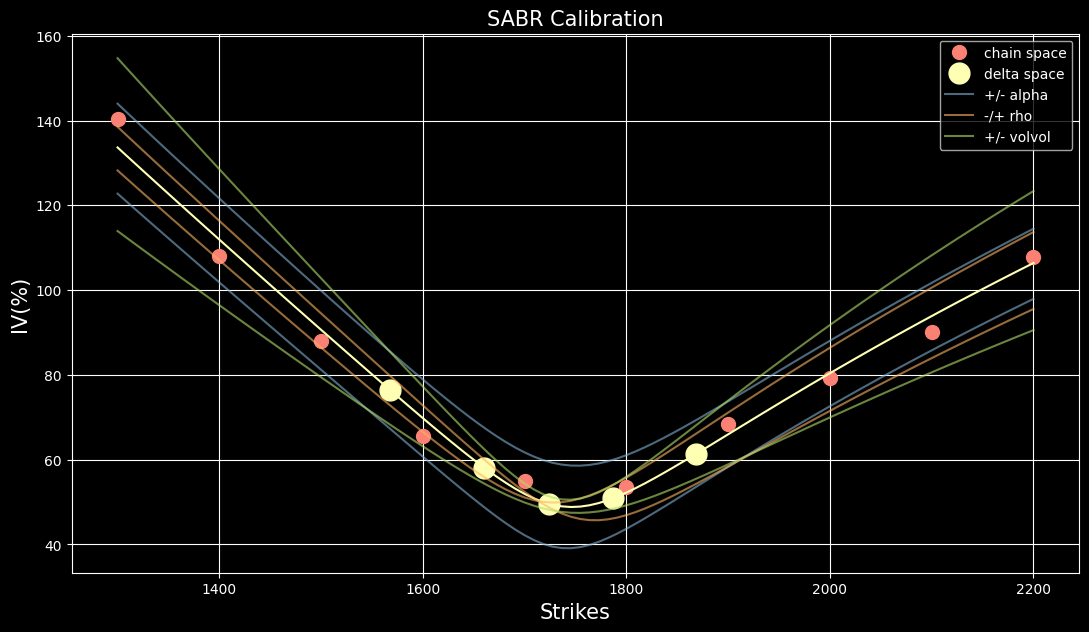

In [27]:
plt.figure(figsize=(13, 7))
plt.plot(strikes, 100*implied_vols, '.C3', markersize=20,  label='chain space')

plt.plot(test_strikes.data, 100*test_iv.data, 'C1')

plt.plot(delta_space_chain.Ks, 100*delta_space_chain.sigmas, '.C1', markersize=30, label='delta space')


plt.plot(test_strikes.data, 
         100*sabr_calc.implied_vols(vol_smile_chain.forward(), test_strikes, calibrated_params.scale_alpha(1.2)).data,
         'C4', label='+/- alpha', alpha=0.6)
plt.plot(test_strikes.data, 
         100*sabr_calc.implied_vols(vol_smile_chain.forward(), test_strikes, calibrated_params.scale_alpha(0.8)).data,
         'C4', alpha=0.6)

plt.plot(test_strikes.data, 
         100*sabr_calc.implied_vols(vol_smile_chain.forward(), test_strikes, calibrated_params.scale_rho(2)).data,
         'C5', label='-/+ rho', alpha=0.6)
plt.plot(test_strikes.data, 
         100*sabr_calc.implied_vols(vol_smile_chain.forward(), test_strikes, calibrated_params.scale_rho(0.2)).data,
         'C5', alpha=0.6)


plt.plot(test_strikes.data, 
         100*sabr_calc.implied_vols(vol_smile_chain.forward(), test_strikes, calibrated_params.scale_v(1.2)).data,
         'C6', label='+/- volvol', alpha=0.6)
plt.plot(test_strikes.data, 
         100*sabr_calc.implied_vols(vol_smile_chain.forward(), test_strikes, calibrated_params.scale_v(0.8)).data,
         'C6', alpha=0.6)


plt.title('SABR Calibration', fontsize=15)
plt.xlabel('Strikes', color='white', fontsize=15)
plt.ylabel('IV(%)', color='white', fontsize=15)
plt.grid()
plt.legend(fontsize=10)
plt.show()

#### SABR greeks
Letting $PV = PV_B(\sigma_B)$ to be the present value of a call option (premium), with $PV_B$ denoting the Black-Scholes formula and $\sigma_B$ SABR implied vol. 
The forward value is:
$$
FV =\frac{PV}{D}
$$
where $D$ is our numeraire (or discounting), so that the spot is $S = D \cdot f$

The SABR greeks are given below in terms of Black-Scholes-Merton greeks:

* Sticky Delta (for the call):
$$\Delta_C =  \frac{\partial PV}{\partial S} =  \frac{1}{D}\frac{\partial PV}{\partial f} =  \frac{1}{D}\frac{\partial PV_B}{\partial f} + \frac{1}{D}\frac{\partial PV_B}{\partial \sigma_B} \cdot \left( \frac{\partial \sigma_B}{\partial f} + \frac{\partial \sigma_B}{\partial \alpha}  \frac{\rho v}{f^\beta} \right) = $$
$$ = \Delta_{C,BSM} + \frac{1}{D}\mathcal{V}_{BSM} \cdot \left( \frac{\partial \sigma_B}{\partial f} + \frac{\partial \sigma_B}{\partial \alpha}  \frac{\rho v}{f^\beta} \right)$$
Note that for sticky strike one lets:
$$
\frac{\partial \sigma_B}{\partial \alpha} = 0.
$$
Hence only infinitesimal changes in $f$ are considered ingnoring the correlation with $\alpha$.

For the put one can use the put-call parity:
$$\Delta_{P} = \Delta_{C} - 1$$

* Gamma: 
$$
\Gamma = \frac{\partial \Delta_C}{\partial S} = \frac{\partial \Delta_P}{\partial S}  = \frac{1}{D}\frac{\partial \Delta_C}{\partial f}
$$

$$
= \Gamma_{BSM} + \frac{2}{D}\text{Vanna}_{BSM} \cdot \left( \frac{\partial \sigma_B}{\partial f} + \frac{\partial \sigma_B}{\partial \alpha}  \frac{\rho v}{f^\beta} \right) 
$$

$$
+  \frac{1}{D^2}\text{Volga}_{BSM}\cdot \left( \frac{\partial \sigma_B}{\partial f} + \frac{\partial \sigma_B}{\partial \alpha}  \frac{\rho v}{f^\beta} \right) ^2
$$

$$
+ \frac{1}{D^2} \mathcal{V}_{BSM} \cdot \left( \frac{\partial ^2 \sigma_B}{\partial f^2} + \frac{\partial ^2 \sigma_B}{\partial \alpha \partial f}  \frac{\rho v}{f^\beta}  - \frac{\partial \sigma_B}{\partial \alpha}  \frac{\beta \rho v}{f^{\beta + 1}} \right)
$$

For sticky strike one lets:
$$
\frac{\partial \sigma_B}{\partial \alpha} = \frac{\partial ^2 \sigma_B}{\partial \alpha \partial f} = 0 
$$
above.

* Vega (ATM straddle):

$$
\mathcal{V} = \frac{\partial PV}{\partial \alpha} 
$$
$$
= \mathcal{V}_{BSM} \cdot \left( 
 \frac{\partial \sigma_B}{\partial \alpha} + \frac{\partial \sigma_B}{\partial f} \cdot \frac{\rho f^\beta}{v}\right)
$$
with sticky strike one sets $ \partial \sigma_B /\partial f = 0.$
 
 * Rega (risk reversal):
 $$ \mathcal{R} =\frac{ \partial PV}{\partial  \rho} = \mathcal{V}_{BSM} \frac{\partial \sigma_B}{\partial \rho}$$

 * Sega (butterfly):
$$ \mathcal{S} =\frac{ \partial PV}{\partial  v} = \mathcal{V}_{BSM} \frac{\partial \sigma_B}{\partial v}$$

* Vanna: 
$$
\mathcal{Vanna} = \frac{\partial \mathcal{V}}{\partial S } =\frac{1}{D} \frac{\partial \mathcal{V}}{\partial f }
$$
$$
= \left( \text{Vanna}_{BSM} + \frac{1}{D} \text{Volga}_{BSM}\cdot \left( \frac{\partial \sigma_B}{\partial f} + \frac{\partial \sigma_B}{\partial \alpha}  \frac{\rho v}{f^\beta} \right) \right)\cdot \left( 
 \frac{\partial \sigma_B}{\partial \alpha} + \frac{\partial \sigma_B}{\partial f} \cdot \frac{\rho f^\beta}{v}\right)
$$
$$
+ \frac{1}{D}\mathcal{V}_{BSM} \cdot \left( \frac{\partial ^2 \sigma_B}{\partial f \partial \alpha} + \frac{\partial ^2 \sigma_B}{\partial f^2}  \frac{\rho f^\beta}{v}  + \frac{\partial \sigma_B}{\partial f}  \frac{\beta \rho f^{\beta - 1}}{v} \right)
$$

with sticky strike one gets:
$$
\mathcal{Vanna} = \left( \text{Vanna}_{BSM} + \frac{1}{D} \text{Volga}_{BSM} \cdot \frac{\partial \sigma_B}{\partial f} \right) \cdot  \frac{\partial \sigma_B}{\partial \alpha} + \frac{1}{D}\mathcal{V}_{BSM} \cdot \frac{\partial ^2 \sigma_B}{\partial f \partial \alpha}  
$$


* Volga: 
$$
\mathcal{Volga} = \frac{\partial \mathcal{V}}{\partial \alpha }
$$
$$
= \text{Volga}_{BSM} \cdot \left( 
 \frac{\partial \sigma_B}{\partial \alpha} + \frac{\partial \sigma_B}{\partial f} \cdot \frac{\rho f^\beta}{v}\right)^2
$$
$$
+ \mathcal{V}_{BSM} \cdot \left( \frac{\partial ^2 \sigma_B}{\partial \alpha^2} + \frac{\partial ^2 \sigma_B}{\partial f \partial \alpha}  \cdot \frac{\rho f^\beta}{v} \right)
$$
with sticky strike one lets:
$$
 \frac{\partial \sigma_B}{\partial f}  = \frac{\partial ^2 \sigma_B}{\partial f \partial \alpha} = 0
$$

#### Delta space
Mapping from delta space:
$$
g(K) = \Delta_{BSM} - \delta \equiv 0 
$$
with implied volatility constrained by SABR is achieved computing the smile sensitivity to the strike:
$$
g'(K) = \frac{N'(d_1)}{\sqrt T} \left( -\frac{1}{K\sigma(K)} - \frac{\sigma'(K) \ln \frac{S}{K}}{\sigma^2(K)} - \frac{rT\sigma'(K)}{\sigma^2(K)} + T\sigma'(K)    \right)
$$

##### Example 1: ATM Straddle

In [ ]:
atm_straddle = SingleMaturityVanillas(
            OptionTypes(np.array([False, True])), 
            Strikes(np.array([delta_space_chain.Ks[2], delta_space_chain.Ks[2]])), 
            Notionals(np.array([1000.,1000.])), 
            vol_smile_chain.time_to_maturity()
        )
atm_straddle.Ks

In [ ]:
def sabr_risk(portfolio, vol_smile_chain, calibrated_params):
    bs_calc = BSCalc()
    sabr_calc = SABRCalc()
    forward = vol_smile_chain.forward()
    
    ivs = sabr_calc.implied_vols(forward, portfolio.strikes(), calibrated_params)
    T = portfolio.time_to_maturity().T * np.ones_like(ivs.data)
    
    res_df = pd.DataFrame({
        'present_value': sabr_calc.premiums(forward, portfolio, calibrated_params).data,
        'notional': portfolio.Ns,
        'call': portfolio.is_call,
        'strike': portfolio.Ks,
        'ttm': T,
        'implied_vol': ivs.data,
        
        'delta': bs_calc.deltas(forward, portfolio, ivs).data,
        'sticky_delta': sabr_calc.sticky_deltas(forward, portfolio, calibrated_params, StickyStrike(False)).data,
        'strike_delta': sabr_calc.sticky_deltas(forward, portfolio, calibrated_params, StickyStrike(True)).data,

        'vega': bs_calc.vegas(forward, portfolio, ivs).data,
        'blip_vega': sabr_calc.blip_vegas(forward, portfolio, calibrated_params).data,
        'sticky_vega': sabr_calc.sticky_vegas(forward, portfolio, calibrated_params, StickyStrike(False)).data,
        'strike_vega': sabr_calc.sticky_vegas(forward, portfolio, calibrated_params, StickyStrike(True)).data,

        'blip_rega': sabr_calc.blip_regas(forward, portfolio, calibrated_params).data,
        'rho_rega': sabr_calc.regas_rho(forward, portfolio, calibrated_params).data,
        
        'blip_sega': sabr_calc.blip_segas(forward, portfolio, calibrated_params).data,        
        'volvol_sega': sabr_calc.segas_volvol(forward, portfolio, calibrated_params).data,

        'gamma': bs_calc.gammas(forward, portfolio, ivs).data,
        'sticky_gamma': sabr_calc.sticky_gammas(forward, portfolio, calibrated_params, StickyStrike(False)).data,
        'strike_gamma': sabr_calc.sticky_gammas(forward, portfolio, calibrated_params, StickyStrike(True)).data,
        
        
        'volga': bs_calc.volgas(forward, portfolio, ivs).data,
        'sticky_volga': sabr_calc.sticky_volgas(forward, portfolio, calibrated_params, StickyStrike(False)).data,
        'strike_volga': sabr_calc.sticky_volgas(forward, portfolio, calibrated_params, StickyStrike(True)).data,
        
        'vanna': bs_calc.vannas(forward, portfolio, ivs).data,
        'sticky_vanna': sabr_calc.sticky_vannas(forward, portfolio, calibrated_params, StickyStrike(False)).data,
        'strike_vanna': sabr_calc.sticky_vannas(forward, portfolio, calibrated_params, StickyStrike(True)).data
    })
    
    return res_df, res_df.drop(columns=['notional','call','strike', 'ttm', 'implied_vol']).sum()
 

In [ ]:
leg_risk, total_risk = sabr_risk(atm_straddle, vol_smile_chain, calibrated_params)

In [ ]:
leg_risk

In [ ]:
total_risk

##### Example 2: Risk Reversal

In [ ]:
risk_reversal_10 = SingleMaturityVanillas(
            OptionTypes(np.array([False, True])), 
            Strikes(np.array([delta_space_chain.Ks[0], delta_space_chain.Ks[-1]])), 
            Notionals(np.array([-1000.,1000.])), 
            vol_smile_chain.time_to_maturity()
        )
risk_reversal_10.Ks

In [ ]:
leg_risk_rr, total_risk_rr = sabr_risk(risk_reversal_10, vol_smile_chain, calibrated_params)

In [ ]:
leg_risk_rr

In [ ]:
total_risk_rr.round(2)

##### Example 3: Vega Neutral Butterfly

In [ ]:
butterfly_10 = SingleMaturityVanillas(
            OptionTypes(np.array([False, False, True, True])), 
            Strikes(np.array([delta_space_chain.Ks[0], delta_space_chain.Ks[2], delta_space_chain.Ks[2], delta_space_chain.Ks[-1]])), 
            Notionals(np.array([1000.,-1000., -1000., 1000.])), 
            vol_smile_chain.time_to_maturity()
        )
butterfly_10.Ks

In [ ]:
ivs = np.array([delta_space_chain.sigmas[0], delta_space_chain.sigmas[2], delta_space_chain.sigmas[2], delta_space_chain.sigmas[-1]])
vegas = bs_calc.vegas(forward, butterfly_10, ImpliedVols(ivs))
vegas.data

In [ ]:
butterfly_10.Ns[1:-1] = (vegas.data[0] + vegas.data[-1])  / (-2*vegas.data[1]) * butterfly_10.Ns[1:-1]
butterfly_10.Ns

In [ ]:
leg_risk_bf, total_risk_bf = sabr_risk(butterfly_10, vol_smile_chain, calibrated_params)

In [ ]:
leg_risk_bf

In [ ]:
total_risk_bf.round(2)

#### Warm starting

In [ ]:
new_forward = 1723.25
new_pvs = np.array([ 0.861625,  1.72325 ,  3.4465  ,  6.893   , 26.710375,
                    11.201125,  4.308125,  1.72325 ,  1.72325 ,  0.861625])

In [ ]:
new_implied_vols = bs_calc.implied_vols(
    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(tau)),
    Strikes(strikes),
    Premiums(new_pvs)
).data

In [ ]:
new_vol_smile_chain = VolSmileChainSpace(
    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(tau)),
    Strikes(strikes),
    ImpliedVols(new_implied_vols)
)

In [ ]:
sabr_calc.update_cached_params(calibrated_params)

In [ ]:
new_calibrated_params, error = sabr_calc.calibrate(new_vol_smile_chain, backbone, weights)
print(error.v)
new_calibrated_params.array()

#### BSM limit

In [ ]:
flat_implied_vols = np.ones_like(implied_vols)*0.8
flat_vol_smile_chain = VolSmileChainSpace(
    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(tau)),
    Strikes(strikes),
    ImpliedVols(flat_implied_vols)
)
sabr_calc.update_cached_params(
    SABRParams(Volatility(1.), Correlation(0.), VolOfVol(0.), Backbone(1.0))
)
flat_calibrated_params, error = sabr_calc.calibrate(flat_vol_smile_chain, Backbone(1.0), weights)
print(error.v)
flat_calibrated_params.array()

In [ ]:
flat_test_iv = sabr_calc.implied_vols(
    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(tau)),
    test_strikes,
    flat_calibrated_params
)
new_test_iv = sabr_calc.implied_vols(
    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(tau)),
    test_strikes,
    new_calibrated_params
)
plt.figure(figsize=(13, 7))
plt.plot(strikes, 100*implied_vols, '.C3', markersize=20)
plt.plot(strikes, 100*new_implied_vols, '.C2', markersize=20)
plt.plot(strikes, 100*flat_implied_vols, '.C4', markersize=20)
plt.plot(test_strikes.data, 100*test_iv.data, 'C1')
plt.plot(test_strikes.data, 100*new_test_iv.data, 'C0')
plt.plot(test_strikes.data, 100*flat_test_iv.data, 'C5')
plt.title('Market skew', fontsize=15)
plt.xlabel('Strikes', color='white', fontsize=15)
plt.ylabel('IV(%)', color='white', fontsize=15)
plt.grid()
plt.show()

#### Hagan's original formula

In [ ]:
def hagan_implied_volatility(K,T,f,alpha,beta,rho,gamma):
    z        = gamma/alpha*np.power(f*K,(1.0-beta)/2.0)*np.log(f/K);
    x_z      = np.log((np.sqrt(1.0-2.0*rho*z+z*z)+z-rho)/(1.0-rho))
    A        = alpha/(np.power(f*K,((1.0-beta)/2.0))*(1.0+np.power(1.0-beta,2.0)/24.0*
                               np.power(np.log(f/K),2.0)+np.power((1.0-beta),4.0)/1920.0*
                               np.power(np.log(f/K),4.0)))
    B1       = 1.0 + (np.power((1.0-beta),2.0)/24.0*alpha*alpha/(np.power((f*K),
                1-beta))+1/4*(rho*beta*gamma*alpha)/(np.power((f*K),
                             ((1.0-beta)/2.0)))+(2.0-3.0*rho*rho)/24.0*gamma*gamma)*T
    impVol   = A*(z/x_z) * B1
    B2 = 1.0 + (np.power(1.0-beta,2.0)/24.0*alpha*alpha/
                (np.power(f,2.0-2.0*beta))+1.0/4.0*(rho*beta*gamma*
                alpha)/np.power(f,(1.0-beta))+(2.0-3.0*rho*rho)/24.0*gamma*gamma)*T;


    impVol[np.where(K==f)] = alpha / np.power(f,(1-beta)) * B2;
    return impVol

In [ ]:
for t in [1., .5, .01]:
    print(f'\n////////////// time to maturity = {t} ////////////////')
    for beta in [.5, .95,  1.]:
        print(f'============== beta = {beta} =================')
        for scale in [100., 5., 1.]:
            new_strikes = test_strikes.data / scale
            new_calibrated_params.beta = beta
            error = np.abs(
                sabr_calc.implied_vols(
                    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(t)),
                    Strikes(new_strikes),
                    new_calibrated_params).data\
                - hagan_implied_volatility(new_strikes, t, new_forward, 
                                 new_calibrated_params.alpha, beta, 
                                 new_calibrated_params.rho, new_calibrated_params.v)).max()
            print(f'min strike {new_strikes[0]}, max diff: {error}')
    new_calibrated_params.beta = backbone.beta

### Managing the vol surface with SABR
For different maturities SABR dynamics take place in different $T$-forward measures. Nevertheless the map to the vol smiles and the associated calibrated parameters: 
$$
T \rightarrow \sigma_i(K_i), \left( \alpha^T, \rho^T, v^T \right)
$$
is continuous in $T$. Therefore, after performing a calibration for each maturity $T_j$ separately, one can perform an interpolation for each of the three parameters $(\alpha^{T_j}, \rho^{T_j}, v^{T_j})$, via a cubic spline for example.
 
#### Calendar Arbitrage
The above approach might lead to **calendar arbitrage**: that is when for each moneyness level:

$$
k \equiv \log \frac{K}{f_{t,T}} 
$$

the map:
$$
T \rightarrow \sigma \left(T,K \right)^2T
$$
is not strictly increasing. The quantity on the RHS is called *total implied variance*. Note that for fixed $k$ the strike $K$ evolves as we move the maturity $T$ unless the forward yield is trivial.

#### Market data interpolation
As consequence, a safer approach is interpolation of the market data first. Interpolating the options chain accross maturities is challenging as each maturity typically would contain a different set of strikes. 

A better approach is to map the chain space to delta space. This is achieved by calibrating SABR to existing tenors and compute the ATM straddle, risk reversals and butterflies (as we did in the previous section). As those are now free of strikes on can interpolate each of them accross tenors separetely:
$$
T \rightarrow \sigma_{ATM}(T), \sigma_{\delta RR}(T), \sigma_{\delta BB} (T) 
$$
One should get also the forward curve $T \rightarrow f_{t,T}$. Those interpolations can be achieved with a cubic spline.

Then, given a new maturity date $T_0$ not available in the market data, one maps delta space quotes to the options chain back simply using Black-Scholes:
$$
\sigma_{ATM}(T_0), \sigma_{\delta RR}(T_0), \sigma_{\delta BB} (T_0) \rightarrow \sigma(T_0, K_{\delta,p}), \sigma(T_0, f_{t,T}), \sigma(T_0, K_{\delta,c})
$$
and calibrate SABR to it, getting $\alpha^{T_0}, \rho^{T_0}, v^{T_0}$.



#### Greeks on the surface

SABR greeks are computed according to each time to maturity separetely. For example, the vega of a calendar spread shorting a one-month call $PV_{C,1M}$ and buying a longer dated one, e.g. three-month $PV_{C,3M}$ is:
$$
\mathcal{V}_{PV_{C,3M}-PV_{C,1M}} = \frac{\partial PV_{C,3M}}{\partial \alpha_{3M}} - \frac{\partial PV_{C,1M}}{\partial \alpha_{1M}}
$$

Similarly for volga, rega and sega. 

For delta (and gamma for that matter), this calculation is easier as we just differentiate w.r.t. spot:
$$
\Delta_{PV_{C,3M}-PV_{C,1M}} = \frac{\partial PV_{C,3M}}{\partial S_t} - \frac{\partial PV_{C,1M}}{\partial S_t}
$$

Finally, vanna risk is defined as sensitivity of vega to spot, so it will read:
$$
\text{Vanna}_{PV_{C,3M}-PV_{C,1M}} = \frac{\partial}{\partial S_t}\mathcal{V}_{PV_{C,3M}-PV_{C,1M}} =  \frac{\partial^2 PV_{C,3M}}{\partial S_t \partial \alpha_{3M}} - \frac{\partial^2 PV_{C,1M}}{\partial S_t \partial \alpha_{1M}}
$$

#### Unexplained PnL 

Given the present values $PV_t$, $S_t$ and calibrated parameters $\alpha_t$, $\rho_t$ and $v_t$, we observe the next update in the market $PV_{t+1}$, $S_{t+1}$, calibrate $\alpha_{t+1}$, $\rho_{t+1}$ and $v_{t+1}$ and measure:

$$
PV_{t+1} - PV_t = \Delta_{PV_t} \cdot (f_{t+1} - f_t) + \frac{1}{2} \Gamma_{PV_t} \cdot(f_{t+1} - f_t)^2
$$
$$
+ \mathcal{V}_{PV_t}\cdot(\alpha_{t+1} - \alpha_t) + \mathcal{R}_{PV_t}\cdot(\rho_{t+1} - \rho_t) + \mathcal{S}_{PV_t}\cdot(v_{t+1} - v_t)
$$
$$
+ \frac{1}{2} \mathcal{Vanna}_{PV_t} \cdot (\alpha_{t+1} - \alpha_t) \cdot (f_{t+1} - f_t)   +  \frac{1}{2} \mathcal{Volga}_{PV_t} \cdot (\alpha_{t+1} - \alpha_t)^2
$$
$$
+ \text{Unexplained PnL}
$$

In [ ]:
from deribit_vol_surface import get_vol_surface

In [ ]:
volsurface_chain = get_vol_surface('./deribit_vol_surface.csv')

In [ ]:
from pyquant.sabr import *
sabr_calc = SABRCalc()
volsurface_delta = sabr_calc.surface_to_delta_space(volsurface_chain, Backbone(1.))

In [ ]:
test_T = np.linspace(volsurface_delta.min_T, volsurface_delta.max_T, num=100) 
test_fwd = volsurface_delta.FWD.forward_yields(TimesToMaturity(test_T)).data

In [ ]:
fig, ax1 = plt.subplots(figsize=(13, 7))

ax1.set_ylabel('Forward Yield', color='C0') 
ax1.set_xlabel('Time to Maturity (T)')
ax1.plot(test_T, test_fwd, 'C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx() 
ax2.plot(test_T, volsurface_delta.atm_quotes(TimesToMaturity(test_T)).data, 'C1', label='ATM')
ax2.plot(test_T, test_T*volsurface_delta.atm_quotes(TimesToMaturity(test_T)).data**2, 'C2', label='ATM TOT VAR')
ax2.plot(test_T, volsurface_delta.rr25_quotes(TimesToMaturity(test_T)).data, 'C3', label='RR25')
ax2.plot(test_T, volsurface_delta.bf25_quotes(TimesToMaturity(test_T)).data, 'C4', label='BF25')
ax2.plot(test_T, volsurface_delta.rr10_quotes(TimesToMaturity(test_T)).data, 'C5', label='RR10')
ax2.plot(test_T, volsurface_delta.bf10_quotes(TimesToMaturity(test_T)).data, 'C6', label='BF10')

plt.title('Delta Space SABR Vol Surface', fontsize=15)
fig.tight_layout()
plt.legend()
plt.show()

In [ ]:
test_K = np.linspace(np.min(volsurface_chain.Ks)*0.9, np.max(volsurface_chain.Ks)*1.1, num=100)
test_ivs = sabr_calc.surface_grid_ivs(volsurface_delta, Strikes(test_K), TimesToMaturity(test_T), Backbone(1.)).data

In [ ]:
test_grid_K, test_grid_T = np.meshgrid(test_K, test_T)
test_grid_ivs = test_ivs.reshape(len(test_K), len(test_T))

In [ ]:
fig = go.Figure(data=[go.Surface(z=test_grid_ivs, x=test_grid_K, y=test_grid_T, colorscale='Tealgrn_r'),
                      go.Scatter3d(z=volsurface_chain.sigmas, x=volsurface_chain.Ks, y=volsurface_chain.Ts, mode='markers')
                     ])
fig.update_layout(title='SABR Volatility Surface', template="plotly_dark", width=1000, height=1000)
fig.update_scenes(xaxis_title_text='strike',
                  yaxis_title_text='time to maturity',
                  zaxis_title_text='implied vol')
fig.show()

In [ ]:
ttms = volsurface_chain.times_to_maturities()
ttms.data

In [ ]:
ttm = ttms.data[2]
smileT = volsurface_chain.get_vol_smile(TimeToMaturity(ttm))
calibrated_paramsT, errorT = sabr_calc.calibrate(smileT, Backbone(1.), CalibrationWeights(np.ones_like(smileT.Ks)))
testK = np.linspace(smileT.Ks[0], smileT.Ks[-1], num=100)
test_ivI = sabr_calc.implied_vols(smileT.forward(), Strikes(testK), calibrated_paramsT)

plt.figure(figsize=(13, 7))
plt.plot(smileT.Ks, 100*smileT.sigmas, '.C3', markersize=20,  label='market')

plt.plot(testK, 100*test_ivI.data, 'C1', label='model')

plt.title(f'SABR Calibration T={round(ttm, 4)}', fontsize=15)
plt.xlabel('Strikes', color='white', fontsize=15)
plt.ylabel('IV(%)', color='white', fontsize=15)
plt.grid()
plt.legend(fontsize=10)
plt.show();

#### Calendar Spreads
Hedging an Iron Condor

In [ ]:
vol_smile_T1 = volsurface_delta.get_vol_smile(TimeToMaturity(0.1)).to_chain_space()
short_butterfly_25_T1 = SingleMaturityVanillas(
            OptionTypes(np.array([False, False, True, True])), 
            Strikes(np.array([vol_smile_T1.Ks[1], vol_smile_T1.Ks[2], vol_smile_T1.Ks[2], vol_smile_T1.Ks[-2]])), 
            Notionals(np.array([-1000., 1000., 1000., -1000.])), 
            vol_smile_T1.time_to_maturity()
        )
short_butterfly_25_T1.Ks

In [ ]:
vol_smile_T1.forward().forward_rate().fv

In [ ]:
params_T1,_ = sabr_calc.calibrate(vol_smile_T1, Backbone(1.), CalibrationWeights(np.ones_like(vol_smile_T1.Ks)))
params_T1.array()

In [ ]:
leg_risk_cs_T1, total_risk_T1 = sabr_risk(short_butterfly_25_T1, vol_smile_T1, params_T1)

In [ ]:
vol_smile_T2 = volsurface_delta.get_vol_smile(TimeToMaturity(0.3)).to_chain_space() 
butterfly_25_T2 = SingleMaturityVanillas(
            OptionTypes(np.array([False, False, True, True])), 
            Strikes(np.array([vol_smile_T2.Ks[1], vol_smile_T2.Ks[2], vol_smile_T2.Ks[2], vol_smile_T2.Ks[-2]])), 
            Notionals(np.array([1000., -1000., -1000., 1000.])), 
            vol_smile_T2.time_to_maturity()
        )
butterfly_25_T2.Ks

In [ ]:
params_T2,_ = sabr_calc.calibrate(vol_smile_T2, Backbone(1.), CalibrationWeights(np.ones_like(vol_smile_T2.Ks)))
params_T2.array()

In [ ]:
leg_risk_cs_T2, total_risk_T2 = sabr_risk(butterfly_25_T2, vol_smile_T2, params_T2)

In [ ]:
cs_risk = pd.concat([leg_risk_cs_T1, leg_risk_cs_T2])

In [ ]:
cs_risk[cs_risk.call]

In [ ]:
cs_risk[cs_risk.call].drop(columns=['notional','call','strike', 'ttm', 'implied_vol']).sum()

In [ ]:
cs_risk[~cs_risk.call]

In [ ]:
cs_risk[~cs_risk.call].drop(columns=['notional','call','strike', 'ttm', 'implied_vol']).sum()

## 5. Stochastic Volatility Inspired (SVI) parametrization

SVI can be obtained as large-maturity limit of the Heston model. As SABR, the parametrization is performed per fixed maturity $t$ and might suffer from calendar arbitrage (which one should get rid of interpolating the surface in delta space, just as with SABR).

SVI models the total implied variance over moneyness:
$$
w(t, k) =  \sigma(t,k)^2 \cdot t, \quad k = \log \frac{K}{f_t}
$$
for strike $K$ and forward rate $f_t$ with time to maturity $t$.

The so-called *raw parametrization* of a smile is given by:
$$
w(k) = a + b\{\rho(k - m) + \sqrt{(k - m)^2 + \sigma^2} \}
$$
with all parameters typically allowed to evolve with time to maturity:
* $a$ controls overall variance, ATM straddle risk 
* $b$ controls the butterfly risk
* $\rho$ influences the risk-reversal
* $m$ slides the smile over moneyness
* $\sigma$ controls the ATM curvature of the smile helping to manage the 0.25 delta to 0.1 delta risk for RRs and BFs.

Some desks might find more intuitive Tim Klassen's *jump-wings* parametrization:
* the ATM variance:
$$ v_t = \frac{a + b\{-\rho m + \sqrt{m^2 + \sigma^2} \}}{t} $$
* the ATM skew:
$$ \psi_t = \frac{b}{2\sqrt{v_t t}} (-\frac{m}{\sqrt{m^2 + \sigma^2}} + \rho)$$
* the curvature for puts:
$$ p_t = \frac{b(1 - \rho)}{\sqrt{v_t t}} $$
* the curvature for calls:
$$ c_t = \frac{b(1 + \rho)}{\sqrt{v_t t}} $$
* minimum implied variance:
$$ \tilde{v_t} = \frac{a + b\sigma \sqrt{1 - \rho^2}}{t} $$

Since SVI is only an approximation of a genuine risk neutral model, it might suffer from another form of *static arbitrage*: *butterfly arbitrage*. Butterfly arbitrage appears when premiums form a non-convex function accross strikes for a fixed vanilla type (call or put). 

SVI parametrization is free of butterfly arbitrage if:
$$
g(k) \equiv \left( 1 - \frac{k w'(k)}{2w(k)}\right)^2 - \frac{w'(k)^2}{4} \left( \frac{1}{w(k)} +  \frac{1}{4} \right) + \frac{w''(k)}{2}
$$
is non-negative. The way to deal with regions where $g < 0$  is to first interpolate market data there with a model which is free of butterfly arbitrage such as SABR or Heston, overweighting the quotes in the region within the LM algorithm). The augmented quotes are then refitted with SVI, with the process interatively repearted until $g \geq 0$ everywhere.

## 6. Surface SVI (SSVI)

For mark-price the smile by tenor parametrization is sufficient (e.g. to get delta space quotes). However, for risk accross tenors one should use the SSVI model. The latter is based on the  *natural parametrization*  $\Delta \in \mathbb{R}, \mu \in \mathbb{R}, \rho \in (-1,1), \omega \geq 0 , \zeta >0$ :

$$
w(k) = \Delta + \frac{\omega}{2} \left( 1 + \zeta \rho (k - \mu) \sqrt{ (\zeta(k-\mu) + \rho)^2 + 1 - \rho^2} \right)
$$

which is completely equivalent to the raw parametrisation with same $|\rho| <1$:
$$
(a,b,m,\sigma) =  \left( \Delta + \frac{\omega}{2}(1 - \rho^2), \frac{\omega \zeta}{2}, \mu - \frac{\rho}{\zeta}, \frac{\sqrt{1 - \rho^2}}{\zeta} \right)
$$
and vice-versa: 
$$
(\Delta, \mu, \omega, \zeta) = \left(a - \frac{\omega}{2}(1-\rho^2), m + \frac{\rho \sigma}{\sqrt{1 - \rho^2}}, \frac{2b\sigma}{\sqrt(1 - \rho^2)}, \frac{\sqrt{1-\rho^2}}{\sigma}\right)
$$

The main purpose for introducing this parametrisation, is that we obtain a good fit across tenors in terms of ATM total variance $\theta_t = w^2(t, 0) \cdot t$ for:
$$
\zeta_t = \eta \theta_t^{\lambda}, \quad \rho_t = \alpha e^{-\beta \theta_t} + \gamma
$$
with constants $\lambda, \eta, \beta \geq 0$, and $\alpha, \gamma$ s.t. $|\rho| <1$.

The SSVI parametrisation is given by:
$$
w(t,k) = \frac{\theta_t}{2} \left(1 + \rho_t \zeta_t k + \sqrt{(\zeta_t k + \rho_t)^2 + 1 - \rho^2}  \right)
$$
which corresponds to the natural parametrisation with $\Delta, \mu \equiv 0$.

The SSVI model is typically calibrated directly to delta space quotes. If such are unavailable, they are obtained first by calibrating SVI smiles tenor by tenor (which also provides initial values for SSVI parameters).

In [ ]:
import pyquant.svi
from pyquant.svi import *

In [ ]:
svi_calc = SVICalc()
#T = 0.0001
# set any value for maturity
vol_smile_chain.T = butterfly_10.T
# started params for calibration
svi_calc.raw_cached_params

In [ ]:
def get_svi_weights(vol_smile_chain):
    """
    Generates weights which are bigger to the ATM
    """
    lenght = len(vol_smile_chain.Ks)
    middle = lenght//2
    arr = np.ones(lenght)
    
    for i in range(middle):
        arr[i] = i + 1

    for i in range(middle, lenght):
        arr[i] =  lenght - i + 1
    return CalibrationWeights(arr)

# ordinary variant with all weights equal
# weights = CalibrationWeights(np.ones(len(vol_smile_chain.Ks)))

weights = get_svi_weights(vol_smile_chain)

# calibrate to market, caching params
svi_calibrated_params, svi_error = svi_calc.calibrate(vol_smile_chain, weights, False, False) 
print(svi_error.v)
svi_calibrated_params.array()

In [ ]:
svi_test_iv = svi_calc.implied_vols(vol_smile_chain.forward(), test_strikes, svi_calibrated_params)
svi_delta_space_chain = svi_calc.delta_space(vol_smile_chain.forward(), svi_calibrated_params).to_chain_space()
svi_delta_space_chain.strikes().data

In [ ]:
svi_calibrated_params_delta, __ = svi_calc.calibrate(svi_delta_space_chain, CalibrationWeights(np.ones(5)), False, True)

# with small delta space, e.g. with T = 0.0001, even SABR might not be able to calibrate correctly
print("Delta space params,", svi_calibrated_params_delta.array())
svi_test_iv_delta = svi_calc.implied_vols(vol_smile_chain.forward(), test_strikes, svi_calibrated_params_delta)

In [ ]:
svi_test_iv_delta_cached = svi_calc.implied_vols(vol_smile_chain.forward(), test_strikes, svi_calibrated_params)

In [ ]:
plt.figure(figsize=(13, 7))
plt.plot(strikes, 100*implied_vols, '.C3', markersize=20, label='Market')

plt.plot(delta_space_chain.Ks, 100*delta_space_chain.sigmas, '.C1', markersize=20, label='SABR')
plt.plot(test_strikes.data, 100*test_iv.data, 'C1')

plt.plot(svi_delta_space_chain.Ks, 100*svi_delta_space_chain.sigmas, '.C2', markersize=20, label='SVI')
plt.plot(test_strikes.data, 100*svi_test_iv.data, 'C2')
plt.plot(test_strikes.data, 100*svi_test_iv_delta.data, 'C4', label='SVI-D')

plt.title('SVI vs SABR Calibration', fontsize=15)
plt.xlabel('Strikes', color='white', fontsize=15)
plt.ylabel('IV(%)', color='white', fontsize=15)
plt.grid()
plt.legend(fontsize=10)
plt.show()

In [ ]:
plt.figure(figsize=(18, 9))

plt.plot(strikes, 100*implied_vols, '.C3', markersize=20, label='Market')
plt.plot(test_strikes.data, 100*svi_test_iv.data, 'C2')


plt.plot(test_strikes.data, 
         100*svi_calc.implied_vols(vol_smile_chain.forward(), test_strikes, svi_calibrated_params.scale_a(1.001)).data,
         'C4', label='+/- a', alpha=0.6)


plt.plot(test_strikes.data, 
         100*svi_calc.implied_vols(vol_smile_chain.forward(), test_strikes, svi_calibrated_params.scale_a(0.997)).data,
         'C4', alpha=0.6)



plt.plot(test_strikes.data, 
         100*svi_calc.implied_vols(vol_smile_chain.forward(), test_strikes, svi_calibrated_params.scale_b(1.001)).data,
         'C5', label='+/- b', alpha=0.6)

plt.plot(test_strikes.data, 
         100*svi_calc.implied_vols(vol_smile_chain.forward(), test_strikes, svi_calibrated_params.scale_b(0.9995)).data,
         'C5', alpha=0.6)



plt.plot(test_strikes.data, 
         100*svi_calc.implied_vols(vol_smile_chain.forward(), test_strikes, svi_calibrated_params.scale_rho(1.002)).data,
         'C6', label='+/- rho', alpha=0.6)
plt.plot(test_strikes.data, 
         100*svi_calc.implied_vols(vol_smile_chain.forward(), test_strikes, svi_calibrated_params.scale_rho(0.993)).data,
         'C6', alpha=0.6)



plt.plot(test_strikes.data, 
         100*svi_calc.implied_vols(vol_smile_chain.forward(), test_strikes, svi_calibrated_params.scale_m(1.02)).data,
         'C7', label='+/- m', alpha=0.6)
plt.plot(test_strikes.data, 
         100*svi_calc.implied_vols(vol_smile_chain.forward(), test_strikes, svi_calibrated_params.scale_m(0.99)).data,
         'C7', alpha=0.6)

plt.plot(test_strikes.data, 
         100*svi_calc.implied_vols(vol_smile_chain.forward(), test_strikes, svi_calibrated_params.scale_sigma(1.01)).data,
         'C8', label='+/- sigma', alpha=0.6)
plt.plot(test_strikes.data, 
         100*svi_calc.implied_vols(vol_smile_chain.forward(), test_strikes, svi_calibrated_params.scale_sigma(0.99)).data,
         'C8', alpha=0.6)


plt.title('SVI Calibration', fontsize=15)
plt.xlabel('Strikes', color='white', fontsize=15)
plt.ylabel('IV(%)', color='white', fontsize=15)
plt.grid()
plt.legend(fontsize=10)
plt.show()

In [ ]:
# let's first calibrate to the biggest tau
svi_calc.strike_lower = 0.01
svi_calc.strike_upper = 100.
svi_calc.raw_cached_params = np.array([10.0, 1.0, 0.0, 1.0, 1.0])
svi_volsurface_delta = svi_calc.surface_to_delta_space(volsurface_chain)

In [ ]:
fig, ax1 = plt.subplots(figsize=(13, 7))

ax1.set_ylabel('Forward Yield', color='C0') 
ax1.set_xlabel('Time to Maturity (T)')
ax1.plot(test_T, test_fwd, 'C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx() 
ax2.plot(test_T, svi_volsurface_delta.atm_quotes(TimesToMaturity(test_T)).data , 'C1', label='ATM')
ax2.plot(test_T, test_T*svi_volsurface_delta.atm_quotes(TimesToMaturity(test_T)).data**2, 'C2', label='ATM TOT VAR')
ax2.plot(test_T, svi_volsurface_delta.rr25_quotes(TimesToMaturity(test_T)).data, 'C3', label='RR25')
ax2.plot(test_T, svi_volsurface_delta.bf25_quotes(TimesToMaturity(test_T)).data, 'C4', label='BF25')
ax2.plot(test_T, svi_volsurface_delta.rr10_quotes(TimesToMaturity(test_T)).data, 'C5', label='RR10')
ax2.plot(test_T, svi_volsurface_delta.bf10_quotes(TimesToMaturity(test_T)).data, 'C6', label='BF10')

plt.title('Delta Space SVI Vol Surface', fontsize=15)
fig.tight_layout()
plt.legend()
plt.show()

In [ ]:
svi_calc.raw_cached_params = np.array([0. , 0.1, 0. , 1. , 0.1])
svi_test_ivs = svi_calc.surface_grid_ivs(svi_volsurface_delta, Strikes(test_K), TimesToMaturity(test_T)).data

In [ ]:
fig = go.Figure(data=[go.Surface(z=svi_test_ivs.reshape(len(test_K), len(test_T)), x=test_grid_K, y=test_grid_T, colorscale='turbo'),
                      go.Scatter3d(z=volsurface_chain.sigmas, x=volsurface_chain.Ks, y=volsurface_chain.Ts, mode='markers')
                     ])
fig.update_layout(title='SVI Volatility Surface', template="plotly_dark", width=1000, height=1000)
fig.update_scenes(xaxis_title_text='strike',
                  yaxis_title_text='time to maturity',
                  zaxis_title_text='implied vol')
fig.show()

In [ ]:
ttm = ttms.data[2]
smileT = volsurface_chain.get_vol_smile(TimeToMaturity(ttm))

# weights = CalibrationWeights(np.ones_like(smileT.Ks))
weights = get_svi_weights(smileT)

calibrated_paramsT, errorT = svi_calc.calibrate(smileT, weights)
testK = np.linspace(smileT.Ks[0], smileT.Ks[-1], num=100)
test_ivI = svi_calc.implied_vols(smileT.forward(), Strikes(testK), calibrated_paramsT)

plt.figure(figsize=(13, 7))
plt.plot(smileT.Ks, 100*smileT.sigmas, '.C3', markersize=20,  label='market')

plt.plot(testK, 100*test_ivI.data, 'C1', label='model')

plt.title(f'SVI Calibration T={round(ttm, 4)}', fontsize=15)
plt.xlabel('Strikes', color='white', fontsize=15)
plt.ylabel('IV(%)', color='white', fontsize=15)
plt.grid()
plt.legend(fontsize=10)
plt.show()

In [ ]:
def svi_risk(portfolio, vol_smile_chain, calibrated_params):
    svi_calc = SVICalc()
    svi_calc.raw_cached_params = np.array([1.0, 1.0, 0.0, 1.0, 1.0])
    forward = vol_smile_chain.forward()
    
    ivs = svi_calc.implied_vols(forward, portfolio.strikes(), calibrated_params)
    T = portfolio.T * np.ones_like(ivs.data)
    
    res_df = pd.DataFrame({
        'present_value': svi_calc.premiums(forward, portfolio, calibrated_params).data,
        'notional': portfolio.Ns,
        'call': portfolio.is_call,
        'strike': portfolio.Ks,
        'ttm': T,
        'implied_vol': ivs.data,
        
        'delta': svi_calc.deltas(forward, portfolio, calibrated_params).data,
        'gamma': svi_calc.gammas(forward, portfolio, calibrated_params).data,

        'a_atm_straddle': svi_calc.a_greeks(forward, portfolio, calibrated_params).data,
        'blip_vega': svi_calc.blip_vegas(forward, portfolio, calibrated_params).data,

        'rho_rega': svi_calc.rho_greeks(forward, portfolio, calibrated_params).data,
        'blip_rega': svi_calc.blip_regas(forward, portfolio, calibrated_params).data,

        'b_sega': svi_calc.b_greeks(forward, portfolio, calibrated_params).data,
        'blip_sega': svi_calc.blip_segas(forward, portfolio, calibrated_params).data, 

        'sigma_smile': svi_calc.sigma_greeks(forward, portfolio, calibrated_params).data,

        'm_moneyness': svi_calc.m_greeks(forward, portfolio, calibrated_params).data,
    })
    
    return res_df, res_df.drop(columns=['notional','call','strike', 'ttm', 'implied_vol']).sum()

leg_svi_risk_bf, total_svi_risk_bf = svi_risk(butterfly_10, vol_smile_chain, svi_calibrated_params)

In [ ]:
leg_svi_risk_bf

In [ ]:
total_svi_risk_bf.round(2)

### References
* Hagan, P. S. et al. *Implied volatility formulas for Heston models.* Wilmott 2018.98 (2018)
* Hagan, P.S., Lesniewski, A.S. and Woodward, D.E., *Managing vol surfaces*. Wilmott (93), pp.24-43, (2018)
* Bartlett, B. *Hedging Under SABR Model.* Wilmott Magazine, (2006)
* Oblój, J. *Fine-Tune Your Smile: Correction to Hagan et al*. preprint [arXiv:0708.0998](https://arxiv.org/abs/0708.0998) (2007)
* Paulot, L. *Asymptotic implied volatility at the second order with application to the SABR model.* In Large Deviations and Asymptotic Methods in Finance (pp. 37-69). Springer, Cham. (2015)
* Henry-Labordere, P. *A general asymptotic implied volatility for stochastic volatility models.* preprint [arXiv:cond-mat/0504317
](http://arxiv.org/abs/cond-mat/0504317) (2005)
* Cui, Y. et al. *Full and fast calibration of the Heston stochastic volatility model*, preprint [arXiv:1511.08718
](https://arxiv.org/abs/1511.08718) (2016)
* Gatheral, J. et al. *Arbitrage-free SVI volatility surfaces*, preprint [arXiv:1204.0646](https://arxiv.org/abs/1204.0646) (2013)